<a href="https://colab.research.google.com/github/choudhurysibani120/NYC-Trip-Time-Prediction/blob/main/sibani_choudhury_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Copy of NYC Taxi Data.csv')

Peeking at the data

In [ ]:
data.shape

(1458644, 11)

There are 1458644 rows and 11 columns

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
# checking data-types of variables to identify the numerical and categorical variables
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object


Categorizing the features :¶

Let's divide features into categories:

Geographical: pickup_longitude , pickup_latitude , dropoff_longitude , dropoff_latitude

Time related: pickup_datetime, dropoff_datetime

Identifier: id(not useful for analysis)

Others: vendor_id, passenger_count, store_and_fwd_flag

Target: trip_duratio


Peeking into numerical features¶


Let us check the distribution of the non -target numerical variables

In [ ]:
numerical_cols = ['passenger_count','pickup_longitude' , 'pickup_latitude' , 'dropoff_longitude' , 'dropoff_latitude']
data[numerical_cols].describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01
std,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02
min,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01
25%,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01
50%,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01
75%,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01
max,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01


In [ ]:
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

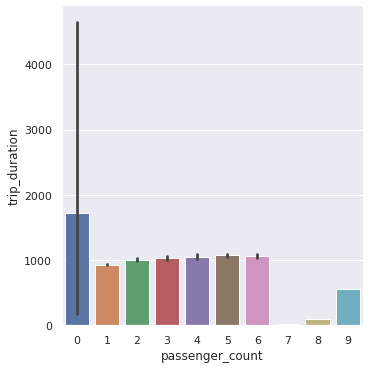

In [ ]:
sns.catplot(x="passenger_count", y="trip_duration",kind="bar",data=data)

In [ ]:
# Checking minimum trip time
data['trip_duration'].min()

1

In [ ]:

# Checking maximum trip time
data['trip_duration'].max()

3526282

In [ ]:
# Checking distribution for trip time
data['trip_duration'].describe().apply(lambda x: format(x, 'f')) #ensuring we get values in float and not in scientific notation

count    1458644.000000
mean         959.492273
std         5237.431724
min            1.000000
25%          397.000000
50%          662.000000
75%         1075.000000
max      3526282.000000
Name: trip_duration, dtype: object

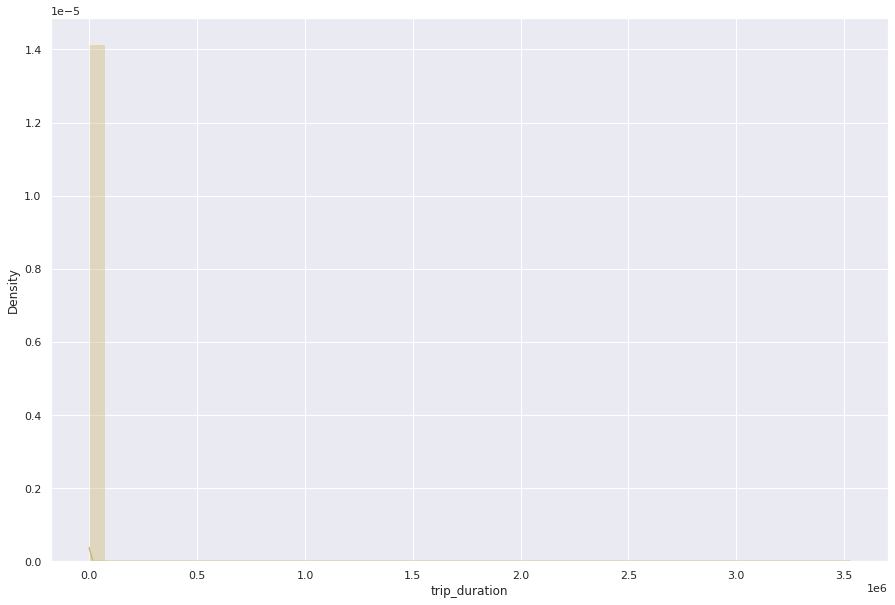

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(data['trip_duration'],color="y")


So we can see there is some skweness in our data. Trip duration is left skewed so handling it by using log transformation to normalize the data

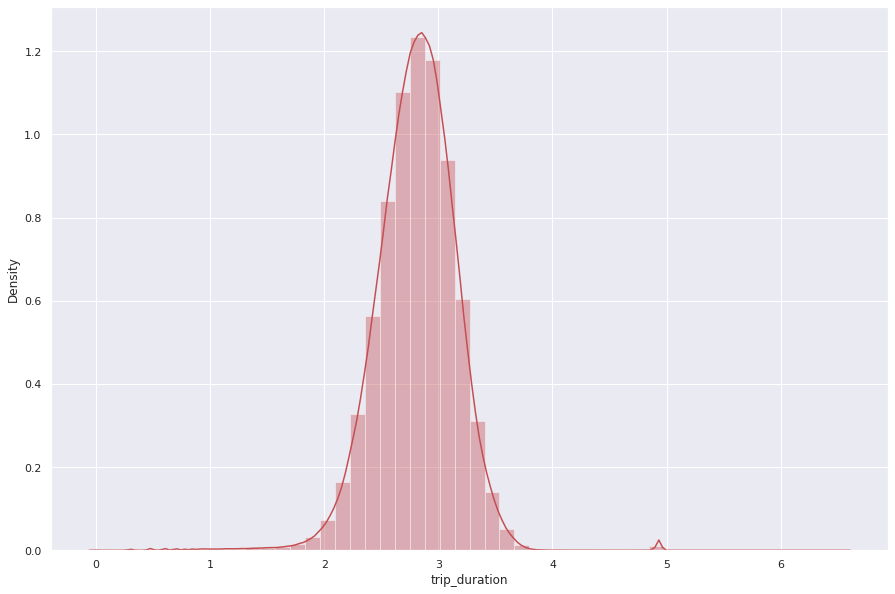

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(np.log10(data['trip_duration']),color="R")

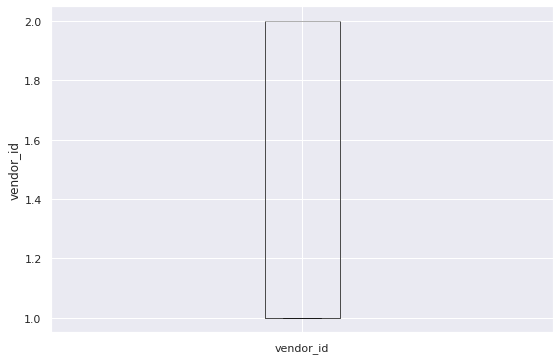

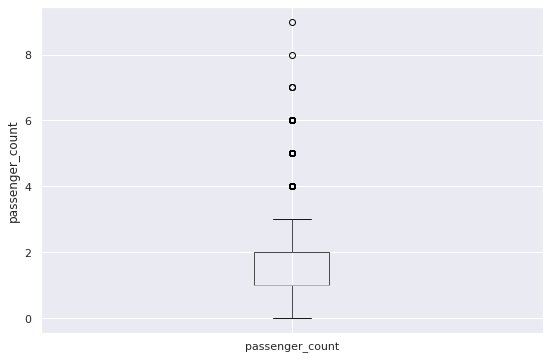

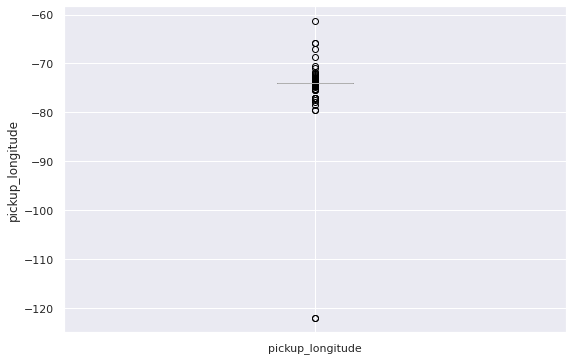

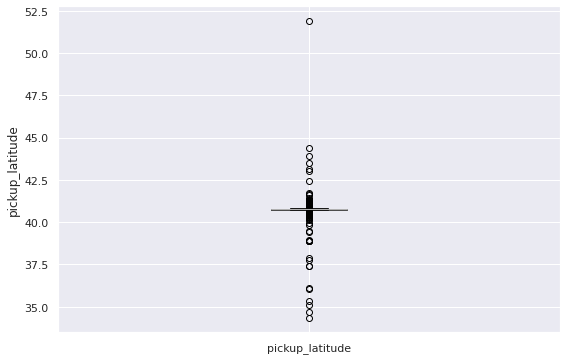

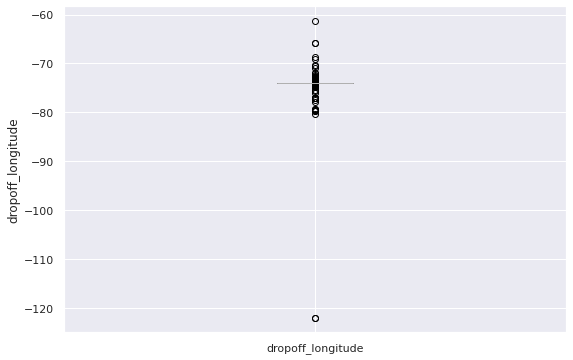

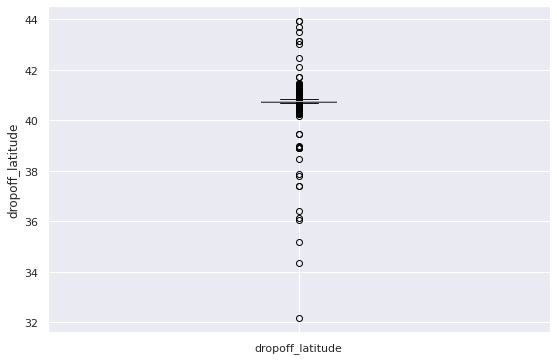

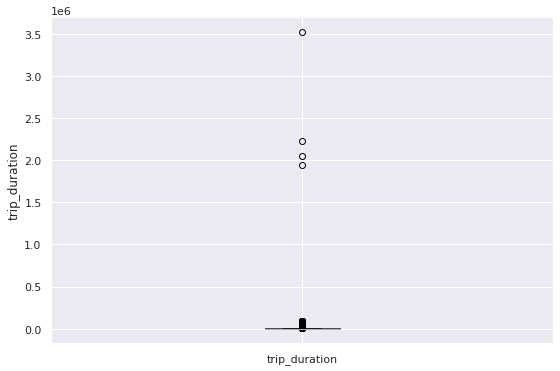

In [ ]:
# plot a boxplot for the label by each numerical feature  
for col in data.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  data.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.show()

Okay so what we know now :

Vendor ID has no outlier.

In passenger count 4 and more passengers are being treated as outliers.

pickup_longitude and pickup_latitude has outliers as well.

dropoff_longitude and dropoff_latitude has outliers too.

Our target variable trip_duration has alot of outliers

In [ ]:
numeric_features = data.describe().columns
numeric_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

(-74.03, -73.75)

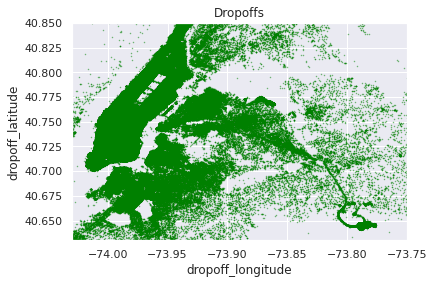

In [ ]:

city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

data.plot(kind='scatter', x='dropoff_longitude',y='dropoff_latitude',
          color='green',
          s=0.2, alpha =.6)
plt.title('Dropoffs')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

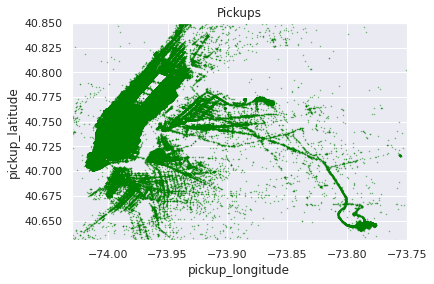

In [ ]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

data.plot(kind='scatter', x='pickup_longitude',y='pickup_latitude',
          color='green',
          s=0.2, alpha =.6)
plt.title('Pickups')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [ ]:
import folium
nyc = folium.Map(location=[40.730610,-73.935242],zoom_start=12,)
nyc

In [ ]:
for i in data.index[:100]:
  folium.CircleMarker(location=[data['pickup_latitude'][i],data['pickup_longitude'][i]],color='green').add_to(nyc)
nyc

In [ ]:
for i in data.index[:100]:
  folium.CircleMarker(location=[data['dropoff_latitude'][i],data['dropoff_longitude'][i]],color='red').add_to(nyc)
nyc

Feature engineering

In [ ]:
data['pickup_day']=data['pickup_datetime'].dt.day_name()
data['dropoff_day']=data['dropoff_datetime'].dt.day_name()
data.head()

AttributeError: ignored

ValueError: ignored

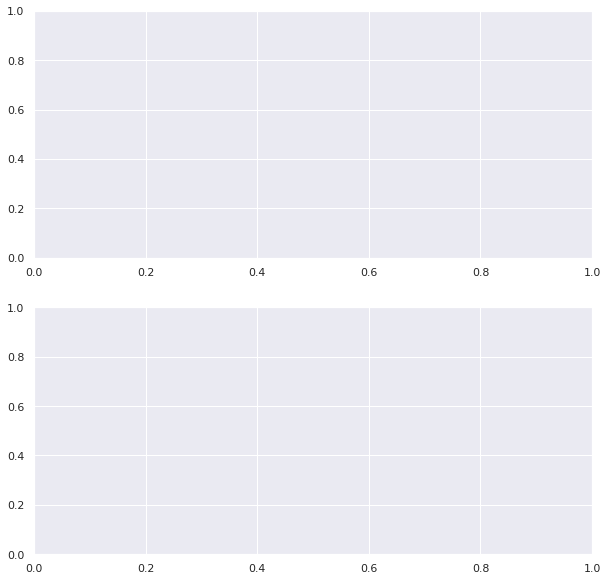

In [ ]:
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=data,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=data,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()